In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

# Model selection and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Metrics for evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer

# ML models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor



In [33]:
# For display formatting
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
np.set_printoptions(precision=3)

In [34]:
# Step 1: Load dataset
df = pd.read_csv("../ML/new_dataset.csv")



PROPERTY PRICE PREDICTION

===== Preprocessing Dataset =====
Removed 0 rows with missing price
Final preprocessed dataset shape: (76370, 38)

===== Training Models for Property =====

Training Linear Regression...
Linear Regression - MAE: 6121469.81, RMSE: 527921563.75, R²: 0.4175, CV R²: -86.4849, Time: 0.14s

Training Ridge Regression...
Ridge Regression - MAE: 6143239.70, RMSE: 529883156.83, R²: 0.4174, CV R²: -86.4927, Time: 0.05s

Training Lasso Regression...
Lasso Regression - MAE: 203425.91, RMSE: 759327.72, R²: 0.2137, CV R²: -0.4060, Time: 0.04s

Training ElasticNet...
ElasticNet - MAE: 228486.87, RMSE: 3116206.17, R²: 0.3310, CV R²: -26.5591, Time: 0.03s

Training Decision Tree...
Decision Tree - MAE: 134110.98, RMSE: 320336.61, R²: 0.6494, CV R²: 0.6437, Time: 0.25s

Training Random Forest...
Random Forest - MAE: 110160.74, RMSE: 270711.64, R²: 0.7402, CV R²: 0.7353, Time: 38.99s

Training Gradient Boosting...
Gradient Boosting - MAE: 128151.84, RMSE: 328828.01, R²: 0.6983

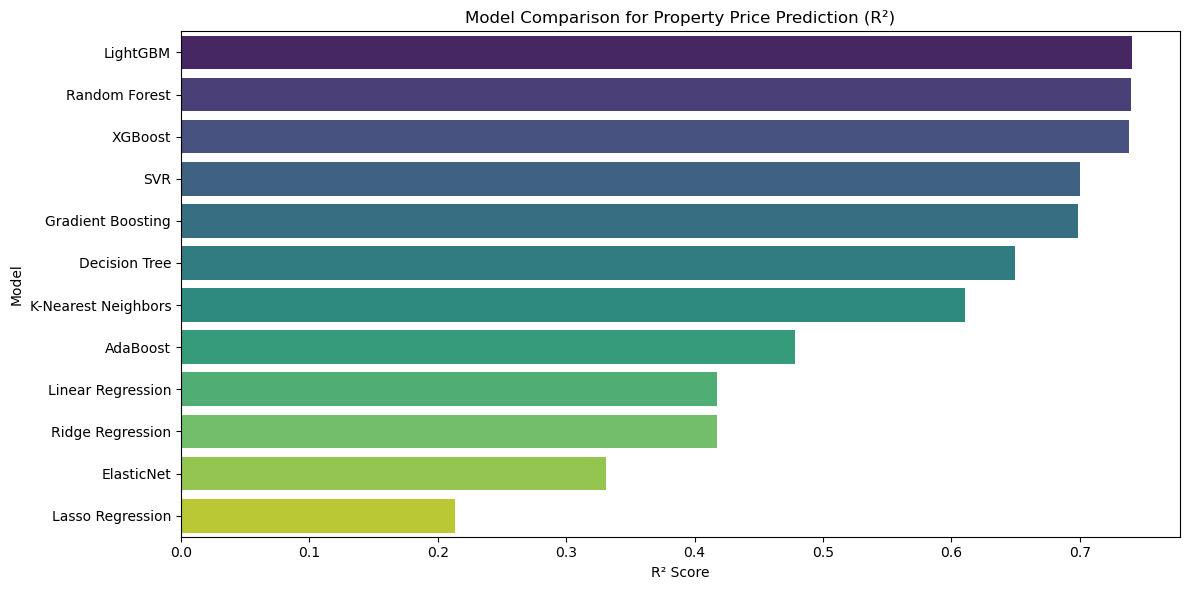

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1951
[LightGBM] [Info] Number of data points in the train set: 61096, number of used features: 31
[LightGBM] [Info] Start training from score 12.753575


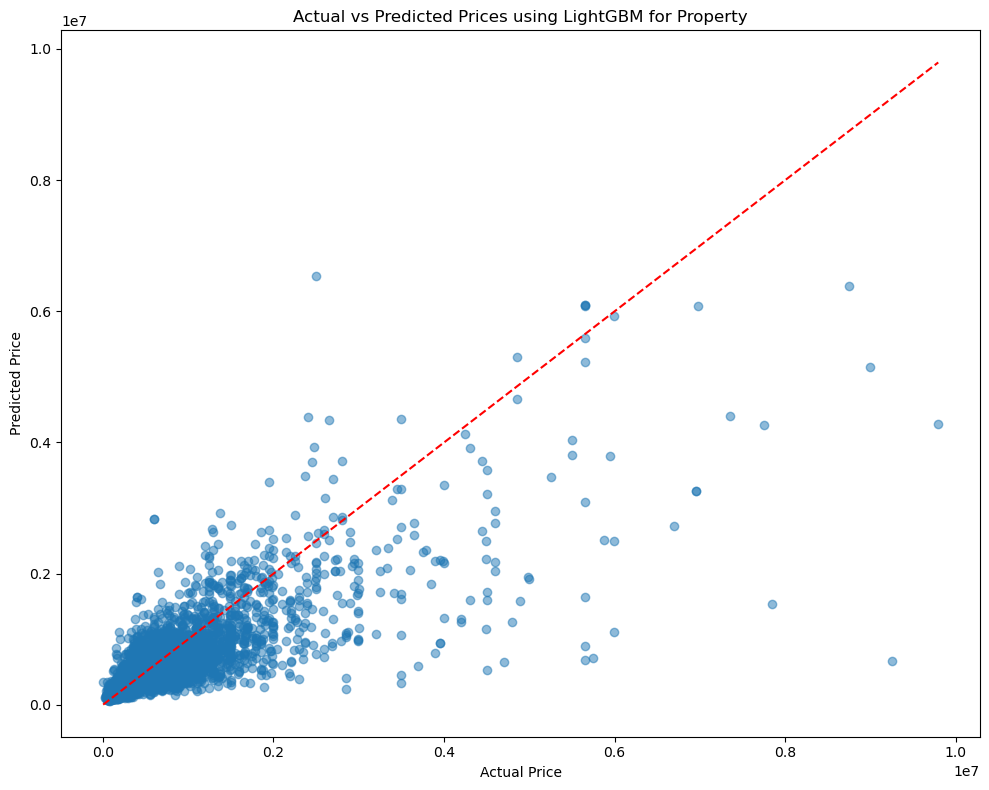

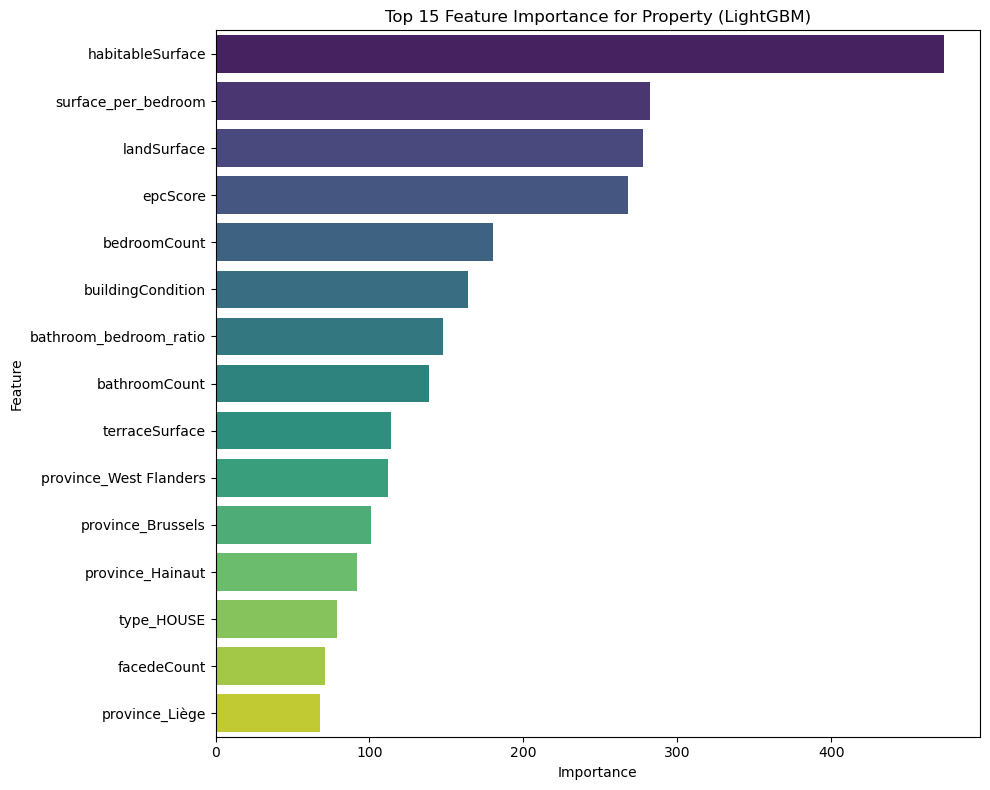


===== Hyperparameter Tuning for LightGBM on Property =====
Fitting 5 folds for each of 108 candidates, totalling 540 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1951
[LightGBM] [Info] Number of data points in the train set: 61096, number of used features: 31
[LightGBM] [Info] Start training from score 12.753575
Best parameters for LightGBM: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 300, 'num_leaves': 127}
Tuned LightGBM - MAE: 0.23, RMSE: 0.32, R²: 0.7579


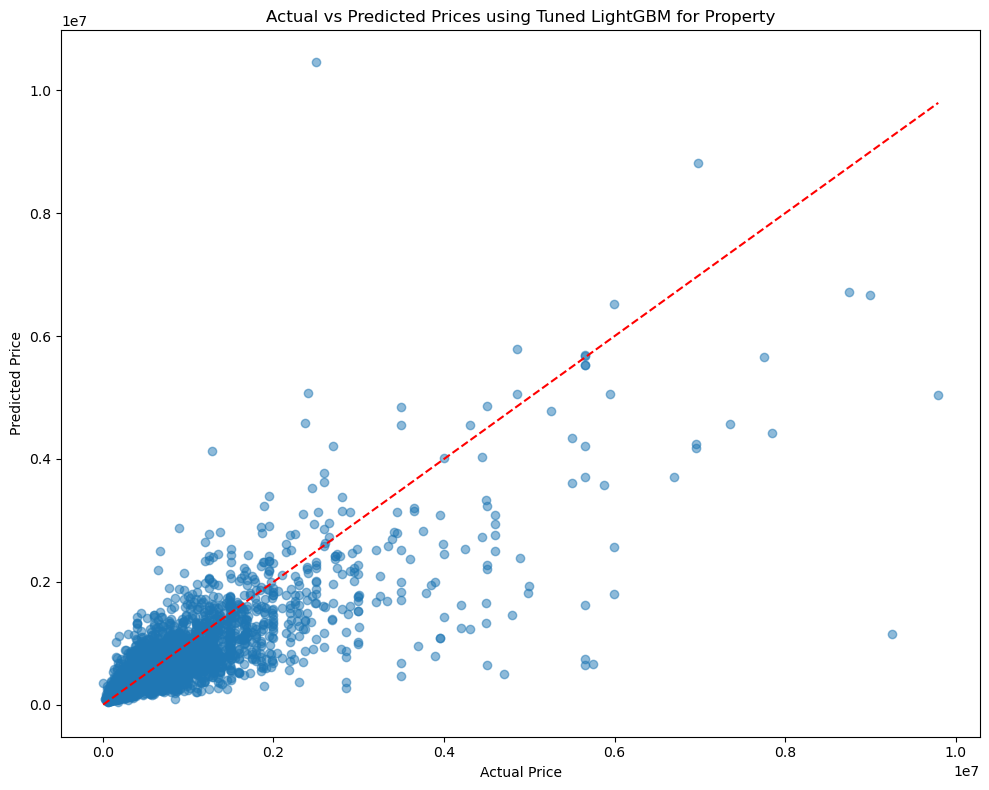



MODEL COMPARISON SUMMARY

Property Models:
               Model        R²           RMSE            MAE
0           LightGBM  0.740959  290653.162769  116675.170580
1      Random Forest  0.740170  270711.637412  110160.741239
2            XGBoost  0.738094  295468.729354  117860.417558
3                SVR  0.699923  310695.856412  123687.467708
4  Gradient Boosting  0.698313  328828.014153  128151.838179


PREDICTION EXAMPLE

To predict a new property price, you would use:
features = [value1, value2, ...]  # Values for each feature
predicted_price = predict_price(features, tuned_model, scaler)


In [35]:
# Step 3: Define Features
selected_features = [
    "type", "province", "bedroomCount", "bathroomCount", 
    "habitableSurface", "epcScore", "buildingCondition", 
    "facedeCount", "hasBasement", "hasAttic", "landSurface", 
    "hasGarden", "gardenSurface", "hasTerrace", "terraceSurface",
    "parkingCountIndoor", "parkingCountOutdoor", "floodZoneType"
]
target = "price"

# Step 4: Enhanced preprocessing function
def preprocess(df, features, target):
    """
    Comprehensive preprocessing pipeline with feature engineering
    """
    print(f"\n===== Preprocessing Dataset =====")
    
    # Create a copy to avoid modifying original data
    df = df[features + [target]].copy()
    
    # Remove rows with missing target
    original_count = df.shape[0]
    df = df.dropna(subset=[target])
    print(f"Removed {original_count - df.shape[0]} rows with missing {target}")
    
    # Ordinal encoding for EPC scores
    epc_order = ['A++', 'A+', 'A', 'B', 'C', 'D', 'E', 'F', 'G']
    epc_enc = OrdinalEncoder(categories=[epc_order], handle_unknown='use_encoded_value', unknown_value=-1)
    
    if 'epcScore' in df.columns:
        df['epcScore'] = df['epcScore'].fillna('Unknown')
        df['epcScore'] = epc_enc.fit_transform(df[['epcScore']])
    
    # Ordinal encoding for building condition
    if 'buildingCondition' in df.columns:
        condition_order = ['TO_RENOVATE', 'TO_RESTORE', 'TO_BE_DONE_UP', 'GOOD', 'JUST_RENOVATED', 'AS_NEW']
        cond_enc = OrdinalEncoder(categories=[condition_order], handle_unknown='use_encoded_value', unknown_value=-1)
        df['buildingCondition'] = df['buildingCondition'].fillna('Unknown')
        df['buildingCondition'] = cond_enc.fit_transform(df[['buildingCondition']])
    
    # One-hot encoding for categorical variables
    cat_cols = ['type', 'province', 'floodZoneType']
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown')
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df = pd.concat([df, dummies], axis=1)
            df.drop(columns=[col], inplace=True)
    
    # Convert boolean columns to float
    bool_cols = [col for col in df.columns if col.startswith('has')]

    for col in bool_cols:
        if col in df.columns:
            df[col] = df[col].astype(float)
    
    # Feature engineering
    if 'habitableSurface' in df.columns and 'bedroomCount' in df.columns:
        df['surface_per_bedroom'] = df['habitableSurface'] / (df['bedroomCount'] + 1)
    
    if 'bathroomCount' in df.columns and 'bedroomCount' in df.columns:
        df['bathroom_bedroom_ratio'] = df['bathroomCount'] / (df['bedroomCount'] + 1)
    
    if 'parkingCountIndoor' in df.columns and 'parkingCountOutdoor' in df.columns:
        df['total_parking'] = df['parkingCountIndoor'] + df['parkingCountOutdoor']
        df.drop(columns=['parkingCountIndoor', 'parkingCountOutdoor'], inplace=True)
    
    # Garden to surface ratio
    if 'gardenSurface' in df.columns and 'habitableSurface' in df.columns:
        df['garden_surface_ratio'] = df['gardenSurface'] / (df['habitableSurface'] + 1)
    
    # Terrace to surface ratio
    if 'terraceSurface' in df.columns and 'habitableSurface' in df.columns:
        df['terrace_surface_ratio'] = df['terraceSurface'] / (df['habitableSurface'] + 1)
    
    # Log transform the target
    y = np.log1p(df[target])
    
    # Handle remaining missing values in numeric columns
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    if target in num_cols:
        num_cols.remove(target)
    
    imputer = SimpleImputer(strategy='median')
    df[num_cols] = imputer.fit_transform(df[num_cols])
    
    X = df.drop(columns=[target])
    
    print(f"Final preprocessed dataset shape: {X.shape}")
    
    return X, y

# Step 5: Advanced model training and evaluation function
def train_evaluate_models(X, y, property_type="Property"):
    """
    Train and evaluate multiple regression models with cross-validation
    """
    print(f"\n===== Training Models for {property_type} =====")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models to train
    models = {
        "Linear Regression": LinearRegression(),
        "Ridge Regression": Ridge(alpha=1.0),
        "Lasso Regression": Lasso(alpha=0.1),
        "ElasticNet": ElasticNet(alpha=0.1, l1_ratio=0.5),
        "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
        "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        "LightGBM": LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
        "AdaBoost": AdaBoostRegressor(n_estimators=50, random_state=42),
        "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1),
        "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5)
    }
    
    # Results storage
    results = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'R²', 'CV R²', 'Train Time'])
    
    # Cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Train and evaluate each model
    for name, model in models.items():
        try:
            print(f"\nTraining {name}...")
            start_time = time()
            
            model.fit(X_train_scaled, y_train)
            
            train_time = time() - start_time
            
            y_pred = model.predict(X_test_scaled)
            
            y_test_orig = np.expm1(y_test)
            y_pred_orig = np.expm1(y_pred)
            
            mae = mean_absolute_error(y_test_orig, y_pred_orig)
            rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
            r2 = r2_score(y_test, y_pred)
            
            cv_r2 = np.mean(cross_val_score(model, X, y, cv=kf, scoring='r2'))
            
            results.loc[len(results)] = [name, mae, rmse, r2, cv_r2, train_time]
            
            print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, CV R²: {cv_r2:.4f}, Time: {train_time:.2f}s")
        
        except Exception as e:
            print(f"Error training {name}: {e}")
    
    results = results.sort_values('R²', ascending=False).reset_index(drop=True)
    
    best_model_name = results.iloc[0]['Model']
    best_model = models[best_model_name]
    print(f"\nBest model for {property_type}: {best_model_name} (R² = {results.iloc[0]['R²']:.4f})")
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='R²', y='Model', data=results, palette='viridis')
    plt.title(f'Model Comparison for {property_type} Price Prediction (R²)')
    plt.xlabel('R² Score')
    plt.tight_layout()
    plt.show()
    
    best_model.fit(X_train_scaled, y_train)
    y_pred = best_model.predict(X_test_scaled)
    
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
    plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'Actual vs Predicted Prices using {best_model_name} for {property_type}')
    plt.tight_layout()
    plt.show()
    
    if hasattr(best_model, 'feature_importances_'):
        importances = pd.DataFrame({
            'Feature': X.columns,
            'Importance': best_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(10, 8))
        sns.barplot(x='Importance', y='Feature', data=importances.head(15), palette='viridis')
        plt.title(f'Top 15 Feature Importance for {property_type} ({best_model_name})')
        plt.tight_layout()
        plt.show()
    
    return best_model, results, scaler

# Step 6: Hyperparameter tuning function
def tune_best_model(X, y, model_type, property_type, scaler):
    """
    Perform hyperparameter tuning on the selected model type
    """
    print(f"\n===== Hyperparameter Tuning for {model_type} on {property_type} =====")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    if model_type == "Random Forest":
        model = RandomForestRegressor(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif model_type == "XGBoost":
        model = XGBRegressor(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0],
            'colsample_bytree': [0.8, 0.9, 1.0]
        }
    elif model_type == "Gradient Boosting":
        model = GradientBoostingRegressor(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    elif model_type == "LightGBM":
        model = LGBMRegressor(random_state=42)
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7, -1],
            'num_leaves': [31, 63, 127]
        }
    else:
        print(f"Hyperparameter tuning not implemented for {model_type}")
        return None
    
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scorer,
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    
    print(f"Best parameters for {model_type}: {best_params}")
    
    y_pred = best_model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"Tuned {model_type} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
    
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(y_test_orig, y_pred_orig, alpha=0.5)
    plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'Actual vs Predicted Prices using Tuned {model_type} for {property_type}')
    plt.tight_layout()
    plt.show()
    
    return best_model

# Step 7: Run analysis
print("\n\n=============================================")
print("PROPERTY PRICE PREDICTION")
print("=============================================")
X, y = preprocess(df, selected_features, target)
best_model, results, scaler = train_evaluate_models(X, y, "Property")

# Get best model type
best_model_type = results.iloc[0]['Model']

# Tune the best model
tuned_model = tune_best_model(X, y, best_model_type, "Property", scaler)

# Step 8: Model Summary
print("\n\n=============================================")
print("MODEL COMPARISON SUMMARY")
print("=============================================")
print("\nProperty Models:")
print(results[['Model', 'R²', 'RMSE', 'MAE']].head())

# Function to make predictions
def predict_price(features, model, scaler):
    """
    Make price predictions using the trained model
    """
    features_scaled = scaler.transform([features])
    log_price = model.predict(features_scaled)[0]
    price = np.expm1(log_price)
    return price

# Example of how to use the prediction function
print("\n\n=============================================")
print("PREDICTION EXAMPLE")
print("=============================================")
print("\nTo predict a new property price, you would use:")
print("features = [value1, value2, ...]  # Values for each feature")
print("predicted_price = predict_price(features, tuned_model, scaler)")